### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Deeplabv3

*Author: Pytorch Team*

**DeepLabV3 models with ResNet-50, ResNet-101 and MobileNet-V3 backbones**

_ | _
- | -
![alt](https://pytorch.org/assets/images/deeplab1.png) | ![alt](https://pytorch.org/assets/images/deeplab2.png)

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from roboflow import Roboflow
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

HOME = os.getcwd()
print("HOME:", HOME)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

num_devices = torch.cuda.device_count()
print(f"Número de GPUs disponíveis: {num_devices}")

# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {DEVICE}")

if DEVICE.type == 'cpu':
  print("Atenção: GPU não disponível.")

HOME: /home/gchagas
Número de GPUs disponíveis: 1
DEVICE: cuda


In [ ]:
'''or any of these variants
 model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
 model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
 model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
'''

# Defina uma condição, pode ser uma variável booleana ou baseada em uma entrada
use_pretrained = False  # Altere para False se desejar carregar o modelo a partir do arquivo local

# Caminho para o arquivo do modelo
model_path = '/home/gchagas/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth'

# Condição para escolher entre os dois métodos
if use_pretrained:
    # Método 1: Carregar o modelo com pesos pré-treinados
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
else:
    # Método 2: Carregar a arquitetura do modelo sem os pesos pré-treinados
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)

    # Carregar os pesos do arquivo local
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

# Colocar o modelo no modo de avaliação
model.eval()



Executando um modelo carregado:
Note que ```*argse``` ```**kwargs``` em ```torch.hub.load()``` são usados ​​para instanciar um modelo. Depois de carregar um modelo, como você pode descobrir o que pode fazer com o modelo? Um fluxo de trabalho sugerido é:

* ```dir(model)``` para ver todos os métodos disponíveis do modelo.

* ```help(model.foo)``` para verificar quais argumentos ```model.foo``` são necessários para executar, ```foo``` seria o método desejado




In [ ]:
dir(model)

In [58]:
help(model.train)

Help on method train in module torch.nn.modules.module:

train(mode: bool = True) -> ~T method of torchvision.models.segmentation.deeplabv3.DeepLabV3 instance
    Set the module in training mode.

    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.

    Args:
        mode (bool): whether to set training mode (``True``) or evaluation
                     mode (``False``). Default: ``True``.

    Returns:
        Module: self



All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxiliary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#semantic-segmentation).

Formato de diretório esperado:

```markdown
dataset/
├── images/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
├── masks/
│   ├── img1.png
│   ├── img2.png
│   └── ...
```

In [5]:
path_datasets = os.path.join(HOME, 'datasets')
print("path_datasets:", path_datasets)

path_datasets: /home/gchagas/datasets


In [40]:
# !pip install roboflow

rf = Roboflow(api_key="2VSqY2oc4mr1I0Irk0Zt")
project = rf.workspace("chagas1").project("vessel-e324t-quwjb")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vessel-3 in yolov8:: 100%|█| 458/458 [00:00<00

path_datasets: /home/gchagas/datasets


In [43]:
!mv ./vessel-3 ./datasets/vessel-3

In [63]:
path_datasets_project = os.path.join(path_datasets, 'vessel-3')
print(os.listdir(path_datasets_project))


['test', 'valid', 'README.dataset.txt', 'data.yaml', 'train', 'README.roboflow.txt']


In [76]:
def txt_to_mask(txt_file, img_size=(608, 608), class_id=0, use_hull=False):
    width, height = img_size
    mask = np.zeros((height, width), dtype=np.uint8)

    with open(txt_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if int(parts[0]) != class_id:
                continue  # Pula se a classe for diferente

            if len(parts) < 6 or (len(parts) - 1) % 2 != 0:
                continue  # Pula se não houver pelo menos 3 pontos

            # Converte coordenadas normalizadas para pixels
            coords = [float(p) for p in parts[1:]]
            points = np.array([
                [int(round(x * width)), int(round(y * height))] for x, y in zip(coords[::2], coords[1::2])
            ], dtype=np.int32)

            # Garante que o polígono está fechado
            if not np.array_equal(points[0], points[-1]):
                points = np.vstack([points, points[0]])

            # Se a flag 'use_hull' estiver ativada, aplica a Convex Hull
            if use_hull:
                hull = cv2.convexHull(points)
                cv2.fillPoly(mask, [hull], 255)
            else:
                # Preenche o polígono
                cv2.fillPoly(mask, [points], 255)

    return mask


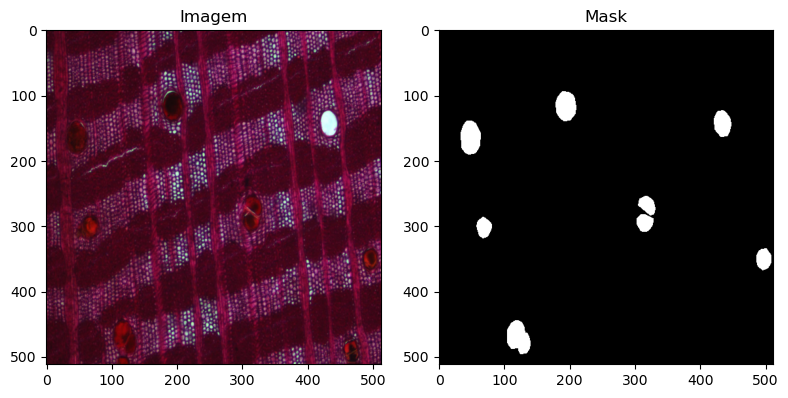

In [10]:
use_hull=True
image_size = (512,512)  # Exemplo de tamanho da imagem (height, width)
class_id = 0  # Classe para a máscara (a mesma classe do arquivo)

path_test = os.path.join(path_datasets_project,'test/images/')
path_lebels = os.path.join(path_datasets_project,'test/labels/')

files = os.listdir(path_test)
filename = files[0]

path_test = os.path.join(path_test, filename)
path_lebels = os.path.join(path_lebels, filename.replace('.jpg', '.txt'))
input_image = Image.open(path_test).resize(image_size)

mask = txt_to_mask(path_lebels, image_size, class_id, use_hull)

# Salvando a máscara
# cv2.imwrite('mask.png', mask * 255)  # Multiplicando por 255 para visualizar a máscara

plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Imagem")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')  # Corrigido para 'gray'
plt.title("Mask")
# plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
class SegmentationDataset():
    def __init__(self, dir, mode='test', transform=None):
        self.image_dir = os.path.join(dir, mode, 'images')
        self.mask_dir = os.path.join(dir, mode, 'labels')
        self.transform = transform
        self.mode = mode
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # The fix: Removed self.mode from the path construction
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        mask_path = mask_path.replace('.jpg', '.txt')

        # Carregando a imagem
        image = Image.open(img_path)

        # Carregando a mask de txt para numpy
        mask = txt_to_mask(mask_path, image_size, class_id, use_hull) # Changed to use mask_path

        # mask = np.expand_dims(mask, axis=-1)  # Adicionando a dimensão extra para o canal

        if self.transform:
            image = image_transform(image)
            mask = Image.fromarray(mask)
            mask = mask_transform(mask)

        return image, mask

In [30]:
# import torch
import torch.optim as optim
from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
from torchvision import datasets

# Supondo que você tenha um Dataset personalizado (como o seu conjunto de dados)
# e que você tenha uma função que retorna as imagens e suas labels.

# Define the transforms for the images and masks separately
image_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    lambda x: x.squeeze(0).long(),
])  # Remove normalization for masks

# Supondo que você tenha um Dataset para carregar as imagens e labels
# Exemplo de um Dataset de PyTorch

mode='train'

#PATH_IMAGES, PATH_LABELS, mode=mode, transform=transform
dataset = SegmentationDataset(path_datasets_project, mode, transform=True)

print(dataset.__len__())

# Configurar DataLoader
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

model.train()  # Colocar o modelo em modo de treinamento
model.to(DEVICE)  # Mover o modelo para o dispositivo (CPU ou GPU)

# Definir a função de perda e o otimizador
criterion = torch.nn.CrossEntropyLoss()  # Para tarefas de segmentação semântica
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Exemplo de otimizador

195


In [31]:
# Loop de treinamento
num_epochs = 250  # Exemplo de número de épocas

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Aplicar o pré-processamento às imagens
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zerar os gradientes do otimizador
        optimizer.zero_grad()

        # Forward pass
        output = model(images)['out']  # Saída da rede

        # Calcular a perda
        loss = criterion(output, labels)

        # Backward pass e otimização
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Após o treinamento, se necessário, salve o modelo
# torch.save(model.state_dict(), 'modelo_treinado.pth')


Epoch [1/10], Loss: 0.09569996424323442
Epoch [2/10], Loss: 0.06304999125399152
Epoch [3/10], Loss: 0.03235374643866505
Epoch [4/10], Loss: 0.02789220274711142
Epoch [5/10], Loss: 0.024710682125724092
Epoch [6/10], Loss: 0.02141996935884259
Epoch [7/10], Loss: 0.01752584835286347
Epoch [8/10], Loss: 0.016534055089007835
Epoch [9/10], Loss: 0.015215896155533135
Epoch [10/10], Loss: 0.014673293340114914


In [81]:
# Function to compute IoU
def mean_iou(y_true, y_pred):
    """
    Calcula o IoU (Intersection over Union) para uma única imagem binária.

    Args:
        y_true: Tensor de verdadeiros (H, W), valores binários (0 ou 1).
        y_pred: Tensor de predições (H, W), valores binários (0 ou 1).

    Returns:
        Valor IoU (float).
    """
    # Verificar se as dimensões das máscaras são iguais
    if y_true.shape != y_pred.shape:
        # Se não forem, fazer o resize de y_pred para o tamanho de y_true
        y_pred = F.interpolate(y_pred.unsqueeze(0).unsqueeze(0), size=y_true.shape, mode='nearest').squeeze()

    # Calcular a interseção e a união
    intersection = torch.logical_and(y_true, y_pred).sum()
    union = torch.logical_or(y_true, y_pred).sum()

    # Evitar divisão por zero
    iou = torch.where(union == 0, torch.tensor(1.0, dtype=torch.float32), intersection / union)
    return iou.item()

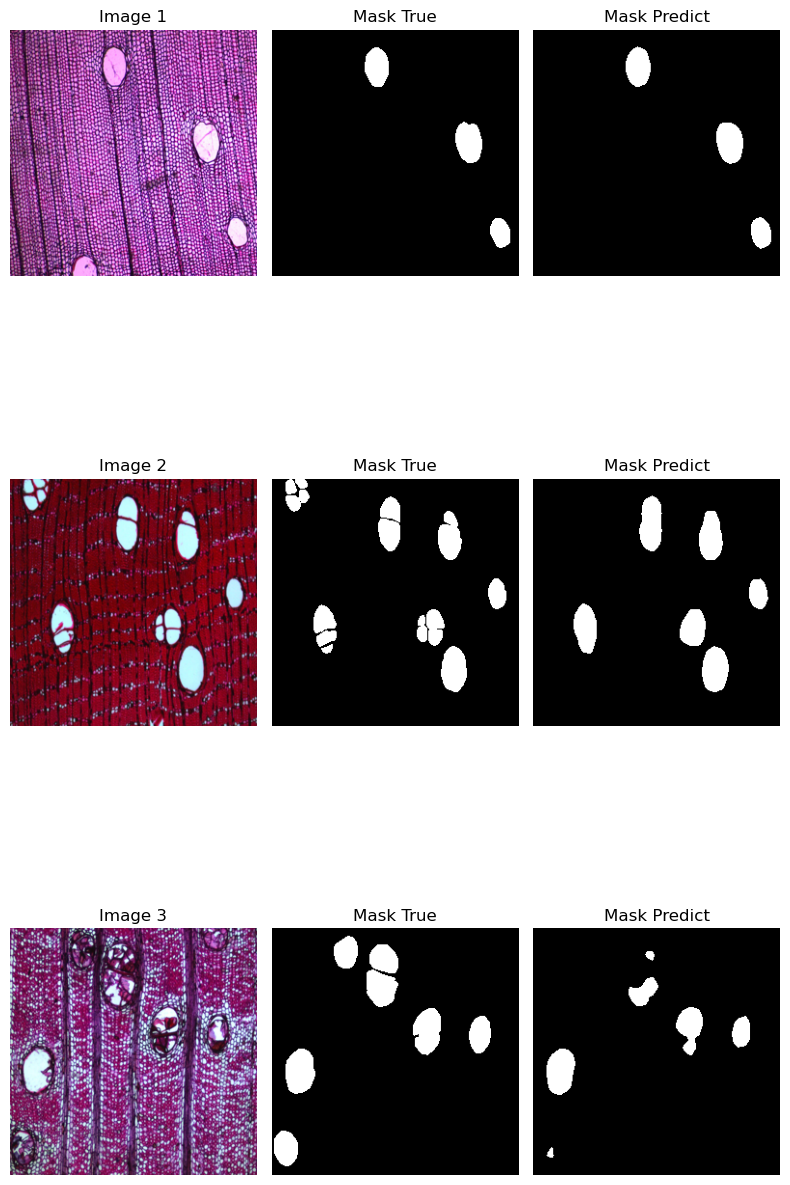

Mean IoU: 0.7492


In [84]:
import math
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import torch.nn.functional as F

# Image size (should be the same size as the model input)
image_size = (256, 256)  # Modify as per your model's requirements

# Path to the dataset
class_id = 0  # Modify as needed
use_hull = False  # Modify as needed

# Preprocessing transform for input image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loop through the images in the 'valid/images' folder
image_folder = os.path.join(path_datasets_project, 'valid', 'images')
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')][:3]

# Initialize variables to calculate mean IoU
total_iou = 0.0
num_images = len(image_files)

# Put the model in evaluation mode
model.to(DEVICE)
model.eval()

# Create a figure for the grid
plt.figure(figsize=(8, 5 * num_images))

for i, image_file in enumerate(image_files):
    # Prepare the image
    path_val = os.path.join(image_folder, image_file)
    input_image = Image.open(path_val).resize(image_size)

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0).to(DEVICE)  # Create mini-batch

    with torch.no_grad():
        # Forward pass
        output = model(input_batch)['out'][0]

    output_predictions = output.argmax(0)

    # Resize the predictions to match the input image size
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(image_size)

    # Load the true mask
    path_labels = path_val.replace('images', 'labels').replace('.jpg', '.txt')
    mask = txt_to_mask(path_labels, image_size, class_id, use_hull)

    # Ensure mask is of dtype uint8 before displaying with imshow
    mask = mask.astype(np.uint8)

    # Convert masks to tensors for IoU calculation
    mask_tensor = torch.tensor(mask, dtype=torch.uint8)
    pred_tensor = torch.tensor(np.array(r), dtype=torch.uint8)

    # Compute IoU for the current image
    iou = mean_iou(mask_tensor, pred_tensor)
    total_iou += iou

    # Plot the images and results in the grid
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(input_image)
    plt.title(f"Image {i + 1}")
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(mask, cmap='gray')  # Display true mask
    plt.title("Mask True")
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(r, cmap='gray')  # Display predicted mask
    plt.title("Mask Predict")
    plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Calculate mean IoU
mean_iou_value = total_iou / num_images
print(f"Mean IoU: {mean_iou_value:.4f}")


The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

### Model Description

Deeplabv3-ResNet is constructed by a Deeplabv3 model using a ResNet-50 or ResNet-101 backbone.
Deeplabv3-MobileNetV3-Large is constructed by a Deeplabv3 model using the MobileNetV3 large backbone.
The pre-trained model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

|    Model structure           |   Mean IOU  | Global Pixelwise Accuracy |
| ---------------------------- | ----------- | --------------------------|
| deeplabv3_resnet50           |   66.4      |   92.4                    |
| deeplabv3_resnet101          |   67.4      |   92.4                    |
| deeplabv3_mobilenet_v3_large |   60.3      |   91.2                    |

### Resources

 - [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)